In [2]:
# Victor Z
# UW-Madison, 2024
# illustrate geometry of Gaussian variables
# used GPT to translate Matlab to Python file

In [1]:
# define ellipse function
# adapted from ellipse.m - Copyright (C) 2001, James B. Rawlings and John W. Eaton

import numpy as np

def ellipse(amat, level, n=100, shift=None):
    if shift is None:
        shift = np.array([0, 0])

    shift = np.asarray(shift)

    if shift.shape != (2,):
        if shift.shape == (2, 1):
            shift = shift.flatten()
        else:
            raise ValueError("shift must be a 2-element row vector")

    if amat.shape != (2, 2):
        raise ValueError("amat must be a 2x2 matrix")

    # Eigenvalues and eigenvectors
    vals, vecs = np.linalg.eig(amat / level)

    if np.any(np.iscomplex(vals)) or np.any(vals <= 0):
        raise ValueError("ellipse: amat must be positive definite")

    # Generate contour data
    a = 1 / np.sqrt(vals[0])
    b = 1 / np.sqrt(vals[1])

    t = np.linspace(0, 2 * np.pi, n)

    xt = a * np.cos(t)
    yt = b * np.sin(t)

    # Rotate the contours
    ra = np.arctan2(vecs[1, 0], vecs[0, 0])

    cos_ra = np.cos(ra)
    sin_ra = np.sin(ra)

    x = xt * cos_ra - yt * sin_ra + shift[0]
    y = xt * sin_ra + yt * cos_ra + shift[1]

    # Endpoints of the major and minor axes
    minor = vecs @ np.diag([a, b])
    major = np.copy(minor)

    major[:, 1] = -major[:, 0]
    minor[:, 0] = -minor[:, 1]

    major += shift
    minor += shift

    # Bounding box for the ellipse using magic formula
    ainv = np.linalg.inv(amat)
    xbox = np.sqrt(level * ainv[0, 0])
    ybox = np.sqrt(level * ainv[1, 1])

    bbox = np.array([
        [xbox, ybox],
        [xbox, -ybox],
        [-xbox, -ybox],
        [-xbox, ybox],
        [xbox, ybox]
    ])

    bbox += shift

    return x, y, major, minor, bbox


In [3]:
# Example usage
amat = np.array([[3, 1], [1, 2]])
level = 5
shift = [1, 1]

x, y, major, minor, bbox = ellipse(amat, level, 100, shift)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2
from mpl_toolkits.mplot3d import Axes3D

# specify mean and covariance
mu1 = np.array([0, 0])
Sigma1 = np.array([[1, -0.5], [-0.5, 1]])  # anti-correlated

# compute the 95% confidence interval ellipse
alpha = 0.95  # confidence
n = 2         # dimension of variable
A = np.linalg.inv(Sigma1)  # inverse covariance
b = chi2.ppf(alpha, n)      # confidence level on 2d from chi2 distribution
xe1, ye1, major1, minor1, bbox1 = ellipse(A, b, 100, mu1)

# 95% marginal intervals
b2 = chi2.ppf(alpha, 1)  # confidence level on 1d from chi2 distribution
xd2 = np.sqrt(b2 * np.diag(Sigma1))
mbox1 = np.tile(mu1, (5, 1)) + np.array([[-xd2[0], -xd2[1]],
                                        [xd2[0], -xd2[1]],
                                        [xd2[0], xd2[1]],
                                        [-xd2[0], xd2[1]],
                                        [-xd2[0], -xd2[1]]])

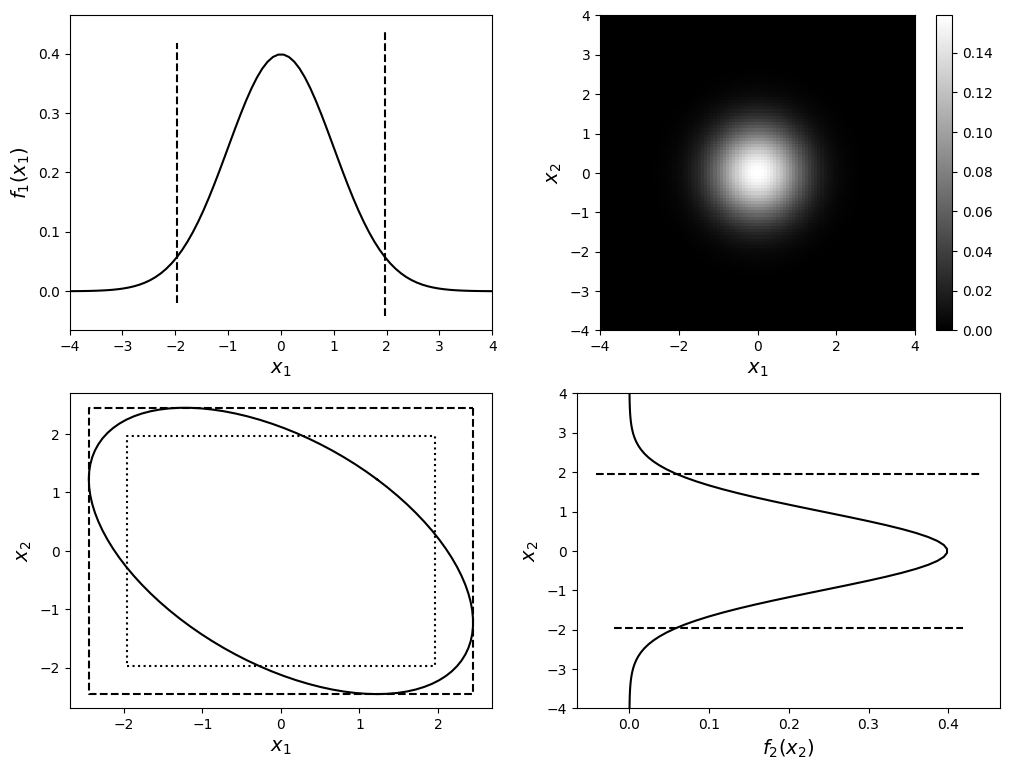

In [8]:
# evaluate probability density function in domain (-5, 5) and (-5, 5)
nmesh = 100
x1 = np.linspace(-5, 5, nmesh)
x2 = np.linspace(-5, 5, nmesh)
X1, X2 = np.meshgrid(x1, x2)
F1 = norm.pdf(x1, mu1[0], np.sqrt(Sigma1[0, 0]))  # pdf on x1
F2 = norm.pdf(x2, mu1[1], np.sqrt(Sigma1[1, 1]))  # pdf on x2
F = np.outer(F1, F2)  # pdf on mesh

# Plotting
fig = plt.figure(1, figsize=(12, 9))

# plot the pdf on x1
plt.subplot(2, 2, 1)
plt.plot(x1, F1, 'k')
plt.plot([mbox1[0, 0], mbox1[0, 0]], plt.ylim(), 'k--')
plt.plot([mbox1[1, 0], mbox1[1, 0]], plt.ylim(), 'k--')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$f_1(x_1)$', fontsize=14)
plt.xlim([mu1[0] - Sigma1[0, 0] * 4, mu1[0] + Sigma1[0, 0] * 4])

# plot the pdf on x2
plt.subplot(2, 2, 4)
plt.plot(F2, x2, 'k')
plt.plot(plt.xlim(), [mbox1[0, 1], mbox1[0, 1]], 'k--')
plt.plot(plt.xlim(), [mbox1[2, 1], mbox1[2, 1]], 'k--')
plt.xlabel('$f_2(x_2)$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.ylim([mu1[1] - Sigma1[1, 1] * 4, mu1[1] + Sigma1[1, 1] * 4])

# plot the pdf on x1,x2
plt.subplot(2, 2, 2)
c = np.linspace(0.99, 0.0, 64)
C = np.tile(c, (3, 1)).T
plt.imshow(F, extent=[mu1[0] - Sigma1[0, 0] * 4, mu1[0] + Sigma1[0, 0] * 4,
                      mu1[1] - Sigma1[1, 1] * 4, mu1[1] + Sigma1[1, 1] * 4], cmap='gray')
plt.colorbar()
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

# plot the ellipse
plt.subplot(2, 2, 3)
plt.plot(xe1, ye1, 'k')  # plot the ellipse
plt.plot(bbox1[:, 0], bbox1[:, 1], 'k--')  # plot the bounding box
plt.plot(mbox1[:, 0], mbox1[:, 1], 'k:')  # plot the marginal box
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)

plt.show()